# 연세-IBM Qiskit User Meetup
## Qiskit Runtime 소개

## Sampler을 사용한 그로버 알고리즘
### Qiskit으로 검색 문제 정의하기
여기 예제에서는 8명 사람의 전화번호가 적혀 있는 작은 전화번호부를 만들어 전화번호부를 보지 않고 우리의 추측이 맞았는지 틀렸는지 알려주는 오라클을 통해 특정한 전화번호의 주인을 찾아보겠습니다.

In [1]:
# Oracle 생성
import random
from qiskit.quantum_info import Statevector

secret = random.randint(0,7)  # the owner is randomly picked
secret_string = format(secret, '03b')  # format the owner in 3-bit string
oracle = Statevector.from_label(secret_string)  # let the oracle know the owner

In [2]:
# Search Problem 생성
from qiskit.algorithms import AmplificationProblem

problem = AmplificationProblem(oracle, is_good_state=secret_string)

그로버 알고리즘의 양자 회로를 생성합니다. 여기서 알고리즘의 정확성은 iteration의 숫자가 많아질수록 올라가는데 1변의 반복과 2번의 반복을 결과값을 보고 비교해봅시다.

In [3]:
# Grover 알고리즘 회로
from qiskit.algorithms import Grover

grover_circuits = []
for iteration in range(1,3):
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem)
    circuit.measure_all()
    grover_circuits.append(circuit)

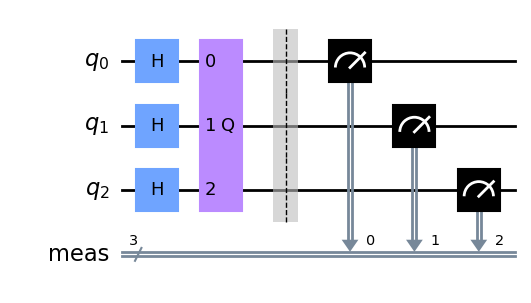

In [4]:
# Grover's circuit with 1 iteration
grover_circuits[0].draw('mpl')

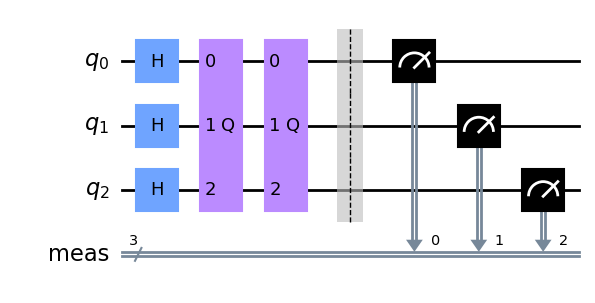

In [5]:
# Grover's circuit with 2 iterations
grover_circuits[1].draw('mpl')

### Qiskit Runtime에 연결하기

그로버 알고리즘은 측정 결과값 중에 가장 높은 결과값을 찾아 출력하기 때문에 Sampler을 사용하기 적합합니다.

In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = "ibmq_qasm_simulator"  # use the simulator

In [7]:
from qiskit_ibm_runtime import Sampler, Session, Options

options = Options(simulator={"seed_simulator": 42}, resilience_level=0)

with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=grover_circuits, shots=1024)
    result = job.result()
    print(result)

SamplerResult(quasi_dists=[{2: 0.033203125, 1: 0.8154296875, 5: 0.0322265625, 7: 0.025390625, 3: 0.0234375, 0: 0.0185546875, 6: 0.0244140625, 4: 0.02734375}, {1: 0.9345703125, 5: 0.0078125, 2: 0.01171875, 6: 0.005859375, 4: 0.0126953125, 0: 0.01171875, 7: 0.009765625, 3: 0.005859375}], metadata=[{'header_metadata': {}, 'shots': 1024}, {'header_metadata': {}, 'shots': 1024}])


### 결과 분석

As you can see, the quantum computer returned '001' as the answer with highest probability.
And the results with 2 iterations have higher probability than the results with 1 iteration.


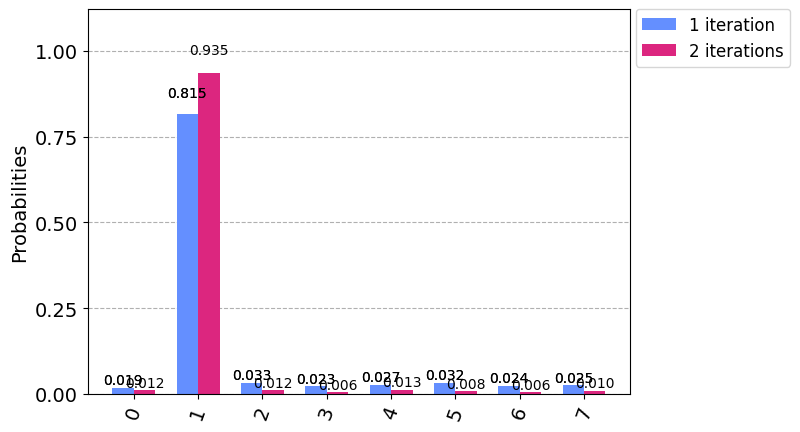

In [8]:
from qiskit.tools.visualization import plot_histogram

# Extract bit string with highest probability from results as the answer
result_dict = result.quasi_dists[1].binary_probabilities()
answer = max(result_dict, key=result_dict.get)
print(f"As you can see, the quantum computer returned '{answer}' as the answer with highest probability.\n"
       "And the results with 2 iterations have higher probability than the results with 1 iteration."
)

# Plot the results
plot_histogram(result.quasi_dists, legend=['1 iteration', '2 iterations'])

In [9]:
# Print the results and the correct answer.
print(f"Quantum answer: {answer}")
print(f"Correct answer: {secret_string}")
print('Success!' if answer == secret_string else 'Failure!')

Quantum answer: 001
Correct answer: 001
Success!


# Estimator을 사용한 Parameterized Circuit

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Options, Estimator
from qiskit import *
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

In [11]:
service = QiskitRuntimeService(channel='ibm_quantum')

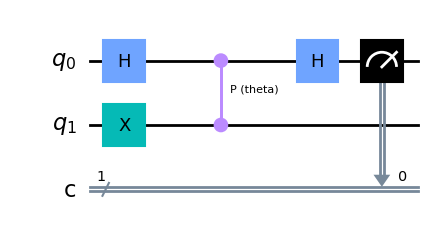

In [12]:
from qiskit.circuit import Parameter # import the parameter class

theta = Parameter('theta')

qc = QuantumCircuit(2,1)
qc.x(1)
qc.h(0)
qc.cp(theta,0,1)
qc.h(0)
qc.measure(0,0)

qc.draw('mpl')

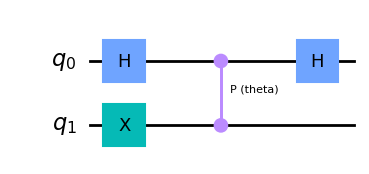

In [13]:
qc_no_meas = qc.remove_final_measurements(inplace=False)
display(qc_no_meas.draw('mpl'))

In [14]:
# individual state 정의하기
phases = np.linspace(0, 2*np.pi, 50) # Specify the range of parameters to look within 0 to 2pi with 50 different phases

# Phases need to be expressed as list of lists in order to work
individual_phases = [[ph] for ph in phases]
print(individual_phases)

[[0.0], [0.1282282715750936], [0.2564565431501872], [0.38468481472528077], [0.5129130863003744], [0.6411413578754679], [0.7693696294505615], [0.8975979010256552], [1.0258261726007487], [1.1540544441758422], [1.2822827157509358], [1.4105109873260295], [1.538739258901123], [1.6669675304762166], [1.7951958020513104], [1.9234240736264039], [2.0516523452014974], [2.179880616776591], [2.3081088883516845], [2.436337159926778], [2.5645654315018716], [2.6927937030769655], [2.821021974652059], [2.9492502462271526], [3.077478517802246], [3.2057067893773397], [3.333935060952433], [3.4621633325275267], [3.5903916041026207], [3.7186198756777142], [3.8468481472528078], [3.9750764188279013], [4.103304690402995], [4.231532961978089], [4.359761233553182], [4.487989505128276], [4.616217776703369], [4.744446048278463], [4.872674319853556], [5.00090259142865], [5.129130863003743], [5.257359134578837], [5.385587406153931], [5.513815677729024], [5.642043949304118], [5.770272220879211], [5.898500492454305], [

### Observable 정의하기

결과값이 아래와 같이 실행됩니다.

$$
\langle ZZ\rangle =\langle \psi | ZZ | \psi\rangle=\langle \psi|(|0\rangle\langle 0| -|1\rangle\langle 1|)\otimes(|0\rangle\langle 0| - |1\rangle\langle 1|) |\psi\rangle =|\langle 00|\psi\rangle|^2 - |\langle 01 | \psi\rangle|^2 - |\langle 10 | \psi\rangle|^2 + |\langle 11|\psi\rangle|^2
$$

In [15]:
ZZ = SparsePauliOp.from_list([("ZZ", 1)])

In [16]:
options = Options(simulator={"seed_simulator": 42}, resilience_level=0)

with Session(service=service, backend=backend):
    estimator = Estimator(options=options)
    job = estimator.run(circuits=[qc_no_meas]*len(phases), parameter_values=individual_phases, observables=[ZZ]*len(phases))
    print(job.result())

EstimatorResult(values=array([-1.    , -0.992 , -0.9625, -0.9195, -0.8805, -0.7895, -0.7265,
       -0.612 , -0.538 , -0.396 , -0.2865, -0.1665, -0.054 ,  0.1   ,
        0.2345,  0.3475,  0.4685,  0.5955,  0.671 ,  0.776 ,  0.8495,
        0.895 ,  0.9445,  0.98  ,  0.9995,  0.996 ,  0.978 ,  0.948 ,
        0.903 ,  0.842 ,  0.76  ,  0.658 ,  0.5615,  0.4745,  0.3325,
        0.2185,  0.0795, -0.0465, -0.167 , -0.2495, -0.397 , -0.4865,
       -0.6165, -0.7065, -0.7825, -0.875 , -0.92  , -0.9645, -0.9905,
       -1.    ]), metadata=[{'variance': 0.0, 'shots': 4000}, {'variance': 0.01593600000000006, 'shots': 4000}, {'variance': 0.0735937499999999, 'shots': 4000}, {'variance': 0.15451975000000007, 'shots': 4000}, {'variance': 0.2247197500000001, 'shots': 4000}, {'variance': 0.37668975000000005, 'shots': 4000}, {'variance': 0.47219774999999997, 'shots': 4000}, {'variance': 0.625456, 'shots': 4000}, {'variance': 0.710556, 'shots': 4000}, {'variance': 0.8431839999999999, 'shots': 4000}, 

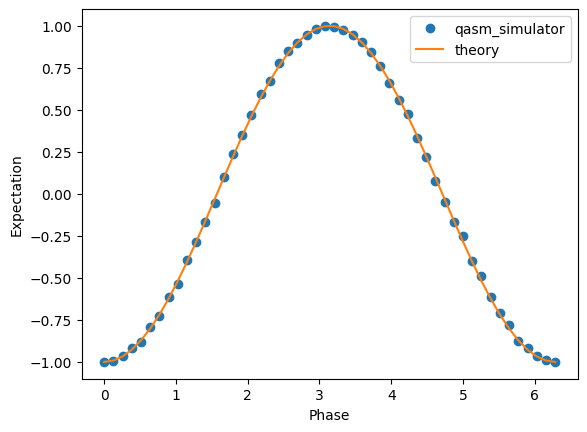

In [17]:
param_results = job.result()
exp_values = param_results.values

plt.plot(phases, exp_values, 'o', label='qasm_simulator')
plt.plot(phases, 2*np.sin(phases/2,)**2-1, label='theory')
plt.xlabel('Phase')
plt.ylabel('Expectation')
plt.legend();

## 노이즈가 있는 시뮬레이터와 Error Mitigation (M3)

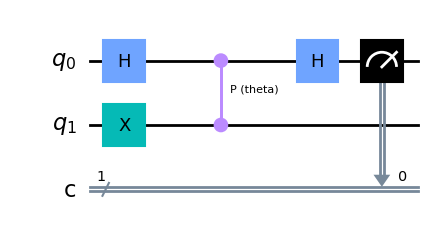

In [22]:
qc.draw('mpl')

### FakeManila - ibmq_manila
![image](https://user-images.githubusercontent.com/79438062/224877768-f3f08b20-5cce-4a1c-86a1-7ec24d8f2e66.png)

In [18]:
from qiskit.providers.fake_provider import FakeManila
from qiskit_aer.noise import NoiseModel

# Import FakeBackend
fake_backend = FakeManila()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include noise_model
options = Options(simulator={
    "noise_model": noise_model,
    "seed_simulator": 42,
}, resilience_level=0)

# Set options to include noise_model and resilience_level
options_with_em = Options(
    simulator={
        "noise_model": noise_model,
        "seed_simulator": 42,
    },  
    resilience_level=1
)

In [19]:
with Session(service=service, backend=backend):
    sampler = Sampler(options=options)
    job = sampler.run(circuits=[qc]*len(phases), parameter_values=individual_phases)
    param_results = job.result()
    prob_values = [1-dist[0] for dist in param_results.quasi_dists]
    
    sampler = Sampler(options=options_with_em)
    job = sampler.run(circuits=[qc]*len(phases), parameter_values=individual_phases)
    param_results = job.result()
    prob_values_with_em = [1-dist[0] for dist in param_results.quasi_dists]

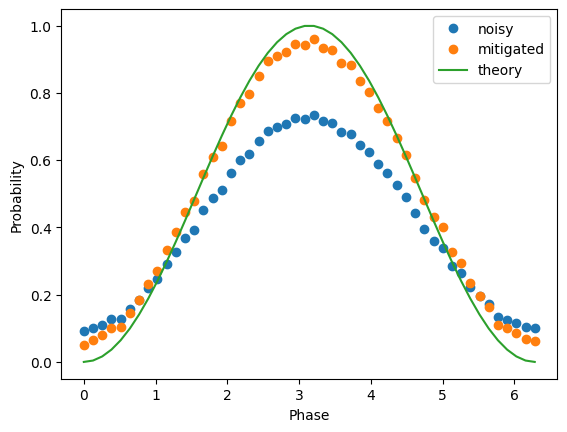

In [20]:
plt.plot(phases, prob_values, 'o', label='noisy')
plt.plot(phases, prob_values_with_em, 'o', label='mitigated')
plt.plot(phases, np.sin(phases/2,)**2, label='theory')
plt.xlabel('Phase')
plt.ylabel('Probability')
plt.legend();

In [21]:
import qiskit.tools.jupyter
%qiskit_version_table

##### Reference
- Qiskit Runtime Tutorials https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/grover_with_sampler.html
- IBM Quantum Fall Challenge 2022 Lab 1